In [ ]:
# !pip install uproot awkward
# !pip install pandas
# !pip install tensorflow
# !pip install keras
# !pip install mplhep
# !pip install pydot
# !pip install iminuit
# !pip install scikit-learn
# !pip install hist
# !pip install scipy

# Introduction

When measuring energy distributions in any experiment, the detector used in such experiments will convolve the true distribution. A feed forward neural network can be trained to recover the initial distribution.

# Preprocessing

Use `uproot` to open ROOT files and process TTrees. Ultimately convert them to pandas dataframes. The `Keras` framework accepts pandas dataframes as input

In [1]:
import uproot
import pandas as pd
import matplotlib.pyplot as plt
import awkward as ak
import numpy as np

In [2]:
figure_dir = "../AlCap/nn-unfolding/figs"
data_dir = "../AlCap"

In [3]:
tree = uproot.open(data_dir + "/transfer.test_0_30_proton_uniform_20E6.root")["oTree"]
arr = tree.arrays(['e1', 'e2', 'e3', 'truth_e', 'channel'], library="np")

In [4]:
branches = tree.arrays()

Use `uproot` methods to perform selection

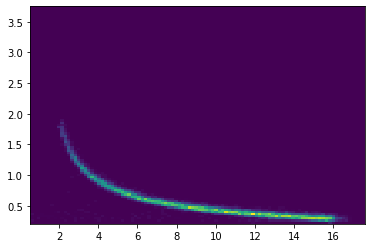

In [5]:
mask = (branches['channel'] == "SiR") & (branches['e3'] == 0.)
e1 = ak.to_numpy(branches['e1'][mask])
e2 = ak.to_numpy(branches['e2'][mask])
e3 = ak.to_numpy(branches['e3'][mask])
_ = plt.hist2d(e1+e2, e1, bins=(100, 100) )

Use panda `dataframes` method to perform event selection

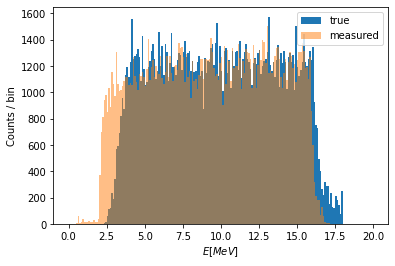

In [6]:
df = pd.DataFrame(arr)
df = df.loc[df["channel"]=="SiR"]
df = df.loc[df["e3"]==0.]
df["E"] = df["e1"] + df["e2"] 

_ = plt.hist(df["truth_e"].to_numpy(), bins=np.arange(0, 20 + .1, .1), label='true' )
_ = plt.hist(df["E"].to_numpy(), bins=np.arange(0, 20 + .1, .1), label='measured', alpha=0.5 )
plt.xlabel(r'$E[MeV]$')
plt.ylabel("Counts / bin")
plt.legend(loc='upper right')

plt.savefig(figure_dir + "/proton_energy-distribution-sir.pdf", format='pdf')

# Training the neural network

A `Sequential` model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor, which is suitable for this work.

The basic building block of a neural network is the layer. Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

Most of deep learning consists of chaining together simple layers. Most layers, such as tf.keras.layers.Dense, have parameters that are learned during training.

In [7]:
import tensorflow
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

Keras models do not like ROOT objects so we drop them for the time being. They cause:
```
ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).
```
specifically `float64` so we convert them to `float32`.

In [8]:
x_train = df.drop(columns=['truth_e', 'channel', 'e3', 'E'])
x_train = x_train.astype(np.float32)
y_train = df["truth_e"].astype(np.float32)

#get number of columns in training data, this should match the input_shape of the input layer of the model
ncols = x_train.shape[1]

Number of inputs

In [9]:
x_train.head()

,e1,e2
99,0.390726,12.955027
284,0.430424,8.916512
406,0.516267,7.756929
415,0.490788,8.510718
467,0.484372,7.681735


The network consists of a sequence of two `tf.keras.layers.Dense` layers. These are densely connected, or fully connected, neural layers. The first Dense layer has 2 nodes (or neurons). The second (and last) layer returns a logits array with length of 1.

In a regression problem, the aim is to predict the output of a continuous value, like a price or a probability. Contrast this with a classification problem, where the aim is to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

The coefficient of determination, $R^2 = 1 - \frac{SS_{res} }{SS_{tot} } $ is the proportion of the variance in the dependent variable that is predictable from the independent variable(s).

where the total sum of squares, $ SS_{tot} = \Sigma_i (y_i - \bar{y} )^2 $

and the sum of squares of residuals, $ SS_{res} = \Sigma_i (y_i - f_i )^2 $

In the best case, the modeled values exactly match the observed values, which results in $SS_{res} = 0$ and $R^2 = 1$. A baseline model, which always predicts $\bar{y}$, will have $R^2 = 0$. Models that have worse predictions than this baseline will have a negative $R^2$. 

In [10]:
# coefficient of determination (R^2) for regression
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

def r_square_loss(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return 1 - ( 1 - SS_res/(SS_tot + K.epsilon()))

In [11]:
model = Sequential()
#hidden layer(s)
model.add(Dense(24, input_shape=(ncols,), kernel_initializer='glorot_uniform', activation='relu')) # relu or sigmoid
#output layer
model.add(Dense(1) )
model.compile(optimizer='adam', loss=[r_square_loss], metrics=[r_square])

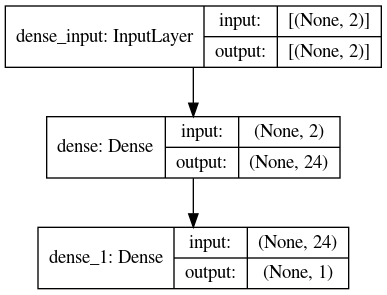

In [12]:
dot_img_file = '/tmp/model_1.png'
tensorflow.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [13]:
#set early stopping monitor
early_stopping_monitor = EarlyStopping(patience=5)

#train model
history = model.fit(x_train, y_train, validation_split=0.25, epochs=60, shuffle=True, verbose=0, callbacks=[early_stopping_monitor])

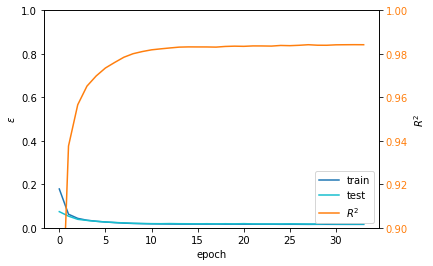

In [14]:
f, a0 = plt.subplots()

p, = a0.plot(history.history['loss'], label='train', color='tab:blue')
q, = a0.plot(history.history['val_loss'], label='test', color='tab:cyan')
a0.set_xlabel("epoch")
a0.set_ylabel(r'$\epsilon$')
a0.set_ylim(0., 1.)
a1 = a0.twinx()
a1.tick_params(labelcolor = 'tab:orange')
r, = a1.plot(history.history['r_square'], label=r'$R^2$', color='tab:orange')
a1.set_xlabel('epoch')
a1.set_ylabel(r'$R^2$')
a1.set_ylim(0.9, 1.0)
plt.legend(handles=[p, q, r], loc="best")
plt.savefig(figure_dir + "/proton_loss-vs-epoch.pdf", format='pdf')

# Hyperparameter space scan with GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_squared_error, r2_score

# let's create a function that creates the model (required for KerasClassifier) 
# while accepting the hyperparameters we want to tune 
# we also pass some default values such as optimizer='adam'
def create_model(layers=1, nodes=2, activation="sigmoid"):
    # define model
    model = Sequential()
    #hidden layer(s)
    for i in range(layers):
        for j in range(nodes):
            model.add(Dense(nodes, input_shape=(ncols,), kernel_initializer='glorot_uniform', activation=activation) ) # relu or sigmoid
    #output layer
    model.add(Dense(1) )
    model.compile(optimizer='adam', loss=[r_square_loss], metrics=[r_square])
    return model

In [ ]:
# define the grid search parameters, write in tuples instead of arrays due to bug: 
# https://github.com/keras-team/keras/issues/13586

validation_split = (0.2, 0.25, 0.3)
epochs = (10, 20, 40, 60, 80,)
nodes = [0, 2, 4, 8, 16, 24]
layers = [1, 2, 4, 8, 16, 24]
activation = ['relu']

model_CV = KerasRegressor(build_fn=create_model, epochs=epochs, 
                           validation_split=validation_split, verbose=1)

param_grid = dict(validation_split=validation_split, epochs=epochs, nodes=nodes, layers=layers, activation=activation)
# cv=3 means stratified 3-Fold is used from (Stratified)KFold
scoring = ["neg_mean_squared_error","r2"]
grid = GridSearchCV(estimator=model_CV, param_grid=param_grid, n_jobs=-1, scoring=scoring, refit='r2', cv=3)
grid_result = grid.fit(x_train, y_train)

In [ ]:
print(f'Best Accuracy for {grid_result.best_score_:.4} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_r2']
stds = grid_result.cv_results_['std_test_r2']
params = grid_result.cv_results_['params']

Load grid search results into pandas DataFrame for easy plotting

In [ ]:
results_df = pd.DataFrame(grid_result.cv_results_)
results_df = results_df.sort_values(by=['param_nodes'])
results_df = (
    results_df
    .set_index(results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
results_df = results_df[
    ['param_nodes', 'param_layers', 'param_epochs', 'param_validation_split', 'mean_test_r2']
]
results_df['param_nodes'] = results_df['param_nodes'].astype(np.uint8)
results_df['param_layers'] = results_df['param_layers'].astype(np.uint8)
results_df['param_epochs'] = results_df['param_epochs'].astype(np.uint8)
results_df['param_validation_split'] = results_df['param_validation_split'].astype(float)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15, 5), dpi=80)
ax = fig.add_subplot(121, projection='3d') # row=1 col=2 cell=1
img = ax.scatter(results_df['param_nodes'], results_df['param_layers'], results_df['param_epochs'], c=results_df['mean_test_r2'], cmap=plt.hot())
ax.set_xlabel("nodes")
ax.set_ylabel("layers")
ax.set_zlabel("epochs")
fig.colorbar(img, pad=0.1)

ax = fig.add_subplot(122, projection='3d')
img = ax.scatter(results_df['param_nodes'], results_df['param_layers'], results_df['param_validation_split'], c=results_df['mean_test_r2'], cmap=plt.hot())
ax.set_xlabel("nodes")
ax.set_ylabel("layers")
ax.set_zlabel("validation_split")
fig.colorbar(img, pad=0.1)

plt.savefig(figure_dir + "/proton_cv-scores.pdf", format='pdf')

Save the results dataframe into hdf5 format for further processing if necessary

In [ ]:
results_df.to_hdf('proton.h5', key='df', mode='w')

# Test with truth data set
We use the trained neural network and apply it to a distribution with known truth of a double Gaussian distribution.

In [15]:
tree = uproot.open(data_dir + "/transfer.dblg.root")["oTree"]
arr = tree.arrays(['e1', 'e2', 'e3', 'truth_e', 'channel'], library="np")
df = pd.DataFrame(arr)
df = df.loc[df["channel"]=="SiR"]
df = df.loc[df["e3"]==0]
df["E"] = df["e1"] + df["e2"]

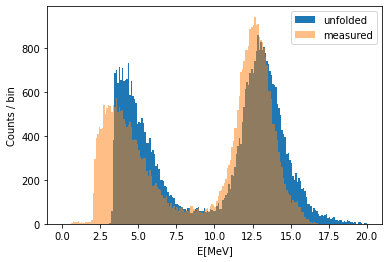

In [16]:
Feedforwardtest = df.drop(columns=['truth_e', 'channel', 'e3', 'E'])
test = Feedforwardtest.astype(np.float32)
prediction = model.predict(test)
_ = plt.hist(prediction, bins=np.arange(0, 20 + .1, .1), label='unfolded' )
_ = plt.hist(df["E"].to_numpy(), bins=np.arange(0, 20 + .1, .1), label='measured', alpha=0.5 )
plt.legend(loc='upper right')
plt.xlabel("E[MeV]")
plt.ylabel("Counts / bin")
plt.savefig(figure_dir + "/proton_gaussian-distribution.pdf", format='pdf')

<ipython-input-17-83063d79853c>:10: RuntimeWarning: divide by zero encountered in true_divide
  _ = a1.plot((xt[:-1] + xt[1:]) / 2.0, (yt - yp) / np.sqrt(yp) )
<ipython-input-17-83063d79853c>:10: RuntimeWarning: invalid value encountered in true_divide
  _ = a1.plot((xt[:-1] + xt[1:]) / 2.0, (yt - yp) / np.sqrt(yp) )


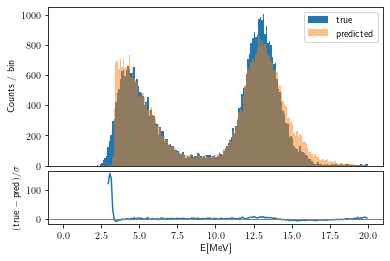

In [17]:
plt.rcParams['text.usetex'] = True
bins=np.arange(0, 20. + .1, .1)
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1] } )
a0.get_xaxis().set_ticks([])
yt, xt, _ = a0.hist(df["truth_e"].to_numpy(), bins, label='true')
yp, xp, _ = a0.hist(prediction, bins, label='predicted', alpha=0.5)
a0.legend(loc='upper right')
a0.set_ylabel("Counts / bin")
#residuals
_ = a1.plot((xt[:-1] + xt[1:]) / 2.0, (yt - yp) / np.sqrt(yp) )
a1.set_xlabel("E[MeV]")
a1.set_ylabel(r'$(\mbox{true} - \mbox{pred}) / \sigma$')
a1.axline((0, 0), (20, 0), linewidth=1, color='grey' )
plt.subplots_adjust(hspace=.05)
plt.savefig(figure_dir + "/proton_gaussian-comparison.pdf", format='pdf')

# Comparisons with other techniques

<ipython-input-18-3f82a02fb4f6>:13: RuntimeWarning: invalid value encountered in true_divide
  _ = a1.plot((xt[:-1] + xt[1:]) / 2.0, (yt - yp) / np.sqrt(yp) )


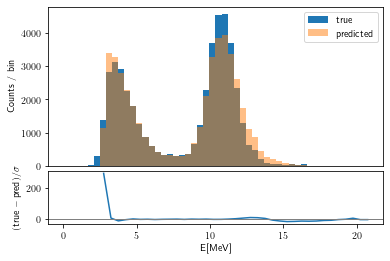

In [18]:
plt.rcParams['text.usetex'] = True
bins=np.arange(0, 25. + .5, .5)
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1] } )
a0.get_xaxis().set_ticks([])
yt, xt, _ = a0.hist(df["truth_e"].to_numpy(), bins, label='true')
yp, xp, _ = a0.hist(prediction, bins, label='predicted', alpha=0.5)
a0.legend(loc='upper right')
a0.set_ylabel("Counts / bin")
#residuals
_ = a1.plot((xt[:-1] + xt[1:]) / 2.0, (yt - yp) / np.sqrt(yp) )
a1.set_xlabel("E[MeV]")
a1.set_ylabel(r'$(\mbox{true} - \mbox{pred}) / \sigma$')
a1.axline((0, 0), (20, 0), linewidth=1, color='grey' )
plt.subplots_adjust(hspace=.05)
plt.savefig(figure_dir + "/proton_gaussian-comparison.pdf", format='pdf')

Prediction threshold at 3.000000 MeV


<ipython-input-19-8684202134d4>:4: RuntimeWarning: invalid value encountered in true_divide
  chi2 =np.power(yt[lower:]-yp[lower:],2) / yt[lower:]
<ipython-input-19-8684202134d4>:6: RuntimeWarning: invalid value encountered in true_divide
  yc, xc, _ = plt.hist((yt[lower:]-yp[lower:]) / np.sqrt(yt[lower:]), bins, label="residuals")
/home/mark/anaconda3/envs/root-env/lib/python3.8/site-packages/scipy/stats/stats.py:6125: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs.astype(np.float64) - f_exp)**2 / f_exp


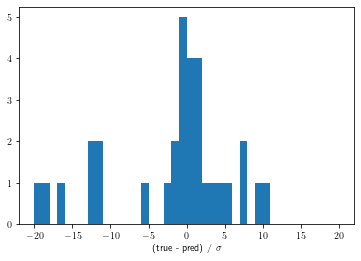

In [19]:
#chi2 distribution
lower = 6
print("Prediction threshold at %f MeV" % (lower/40 * 20) )
chi2 =np.power(yt[lower:]-yp[lower:],2) / yt[lower:]
bins=np.arange(-20, 20 + 1, 1)
yc, xc, _ = plt.hist((yt[lower:]-yp[lower:]) / np.sqrt(yt[lower:]), bins, label="residuals")
plt.xlabel(r'(true - pred) / $\sigma$')
plt.savefig(figure_dir + "/alpha_diff.pdf", format='pdf')

from scipy.stats import chisquare
from scipy import stats
chi2 = chisquare(yp[lower:], f_exp=yt[lower:])

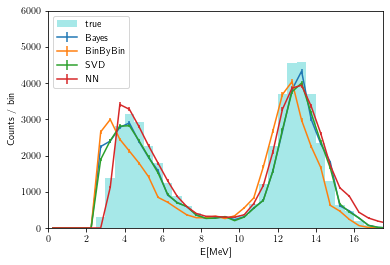

In [20]:
bins=np.arange(0, 25. + .5, .5)
comp = uproot.open("../RooUnfold/validation.transfer.dblg.root")
plt.errorbar((comp['hBayes'].to_numpy()[1][:-1] + comp['hBayes'].to_numpy()[1][1:]) / 2., comp['hBayes'].to_numpy()[0], np.sqrt(comp['hBayes'].to_numpy()[0] ), label='Bayes')
plt.errorbar((comp['hBinByBin'].to_numpy()[1][:-1] + comp['hBinByBin'].to_numpy()[1][1:]) / 2., comp['hBinByBin'].to_numpy()[0], np.sqrt(comp['hBinByBin'].to_numpy()[0] ), label='BinByBin')
plt.errorbar((comp['hSvd'].to_numpy()[1][:-1] + comp['hSvd'].to_numpy()[1][1:]) / 2., comp['hSvd'].to_numpy()[0], np.sqrt(comp['hBinByBin'].to_numpy()[0] ), label='SVD')
plt.errorbar((xp[:-1] + xp[1:]) / 2., yp, np.sqrt(yp), label='NN')
plt.hist(df["truth_e"].to_numpy(), np.arange(0, 17.5 + .5, .5), color='c', alpha=.35, label='true')
plt.legend(loc='upper left')
plt.xlim([0, 17.5])
plt.ylim([0, 6000])
plt.xlabel("E[MeV]")
plt.ylabel("Counts / bin")
plt.savefig(figure_dir + "/proton_other-comparison.pdf", format='pdf')

<ipython-input-21-cf9ebe98fc78>:3: RuntimeWarning: invalid value encountered in true_divide
  _ = plt.plot((comp['hBayes'].to_numpy()[1][:-1] + comp['hBayes'].to_numpy()[1][1:]) / 2.      , np.divide(yt - comp['hBayes'].to_numpy()[0]    , np.sqrt(comp['hBayes'].to_numpy()[0] ) ), label='Bayes' )
<ipython-input-21-cf9ebe98fc78>:4: RuntimeWarning: invalid value encountered in true_divide
  _ = plt.plot((comp['hBinByBin'].to_numpy()[1][:-1] + comp['hBinByBin'].to_numpy()[1][1:]) / 2., np.divide(yt - comp['hBinByBin'].to_numpy()[0] , np.sqrt(comp['hBinByBin'].to_numpy()[0] ) ), label='BinByBin' )
<ipython-input-21-cf9ebe98fc78>:5: RuntimeWarning: invalid value encountered in sqrt
  _ = plt.plot((comp['hSvd'].to_numpy()[1][:-1] + comp['hSvd'].to_numpy()[1][1:]) / 2.          , np.divide(yt - comp['hSvd'].to_numpy()[0]      , np.sqrt(comp['hSvd'].to_numpy()[0] ) ), label='SVD' )
<ipython-input-21-cf9ebe98fc78>:5: RuntimeWarning: invalid value encountered in true_divide
  _ = plt.plot((comp['

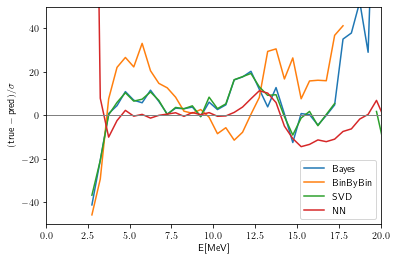

In [21]:
plt.rcParams['text.usetex'] = True
bins=np.arange(0, 25 + .5, .5)
_ = plt.plot((comp['hBayes'].to_numpy()[1][:-1] + comp['hBayes'].to_numpy()[1][1:]) / 2.      , np.divide(yt - comp['hBayes'].to_numpy()[0]    , np.sqrt(comp['hBayes'].to_numpy()[0] ) ), label='Bayes' )
_ = plt.plot((comp['hBinByBin'].to_numpy()[1][:-1] + comp['hBinByBin'].to_numpy()[1][1:]) / 2., np.divide(yt - comp['hBinByBin'].to_numpy()[0] , np.sqrt(comp['hBinByBin'].to_numpy()[0] ) ), label='BinByBin' )
_ = plt.plot((comp['hSvd'].to_numpy()[1][:-1] + comp['hSvd'].to_numpy()[1][1:]) / 2.          , np.divide(yt - comp['hSvd'].to_numpy()[0]      , np.sqrt(comp['hSvd'].to_numpy()[0] ) ), label='SVD' )
_ = plt.plot((xp[:-1] + xp[1:]) / 2., (yt - yp) / np.sqrt(yp), label='NN' )

plt.axline((0, 0), (20, 0), linewidth=1, color='grey' )
plt.xlim([0, 20])
plt.ylim([-50, 50])
plt.xlabel("E[MeV]")
plt.ylabel(r'$(\mbox{true} - \mbox{pred}) / \sigma$')
plt.legend(loc='lower right')
plt.savefig(figure_dir + "/proton_comparison-diff.pdf", format='pdf')

# Closure tests

Fitting experimental data is often complicated by a number of factors unrelated to the methodology itself, such as possible dataset inconsistencies (either internal or external) or inadequacies of the theoretical description adopted.

Therefore, it is far from optimal to assess the benefits of an specific fitting methodology by applying it to the actual data, while it is much more robust to test it instead in an analysis of pseudo-data generated from a fixed (known) underlying theory.

We construct independent Monte Carlo samples where the underlying truth distributions are modified. One expects to obtain unbiased results when unfolding observations drawn from the changed truth distribution.

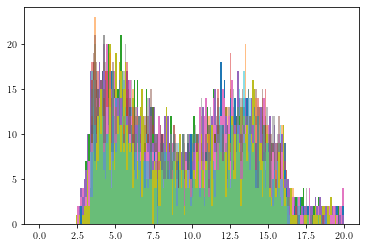

In [22]:
from scipy.stats import ks_2samp
ks_arr = []
for i in range(1, 101):
    tree = uproot.open(data_dir + "/closure/transfer.closure_1.5_20_proton_%s.root" % i )["oTree"]
    arr = tree.arrays(['e1', 'e2', 'e3', 'truth_e', 'channel'], library="np")
    df = pd.DataFrame(arr)
    df = df.loc[df["channel"]=="SiR"]
    df = df.loc[df["e3"]==0]
    _data = df.drop(columns=['truth_e', 'channel', 'e3'])
    test = _data.astype(np.float32)
    prediction = model.predict(test)

    lower = 33
    upper = -34    
    bins=np.arange(0, 20 + .1, .1)   
    yt, xt, _ = plt.hist(df["truth_e"].to_numpy(), bins, label='true')
    yp, xp, _ = plt.hist(prediction, bins, label='predicted', alpha=0.5)

    #K-S test calculation, set lower and upper energy threshold for proper calculation which avoids zeroes.
    ks = ks_2samp(yt[lower:upper], yp[lower:upper])
    ks_arr.append(ks.pvalue)

## Kolmogorov-Smirnov test results

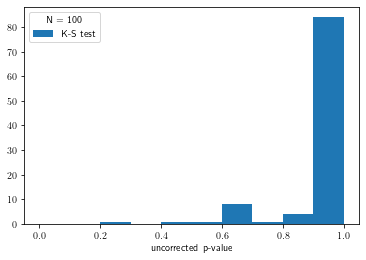

In [23]:
_ = plt.hist(ks_arr, bins=np.arange(0, 1 + .1, .1), label="K-S test")
fit_info = [
    f'N = {len(ks_arr)}',
]
plt.legend(title="\n".join(fit_info))
plt.xlabel(r'uncorrected p-value')
plt.savefig(figure_dir + "/proton_kspvalue_100toy.pdf", format='pdf')